Cosas para procesamiento de imágenes:
* Evaluar características de la cámara
* Normalización (ver si los índices normalizan o estudiar si la normalización rompe el índice)
* Medir más características en el final, para discriminar de otra manera, ej: índice de textura

Informe breve que describa las acciones realizadas para todas las etapas, decisiones en cada una, resultados

## Preprocesamiento
Indices seleccionados:
* Cloudy days: CIVE
* Sunny days: ExG

Las partes quemadas de la imagen afectan en los índices (es algo esperado).<br>
Hay que probar las otras configuraciones de la cámara para detectar si las imágenes se queman.<br><br>
Conocimiento previo para el algoritmo:
* Cantidad de lineas en la imagen
* Estadio del cultivo para estimar ancho de cada linea
<br>

#### Aprendido
* Equalización de V en HSV rompe índices de vegetación (al menos los que trabajan con RGB)

#### Notas
* Cuando se haga el port, las imágenes binarizadas (uint8) cambiarlas a estructuras de Boolean
* Para la detección de las rectas es bueno tener un microROI angosto (respecto al ancho del surco), para la máscara posterior es bueno agrandar su ancho real para solventar el problema de las hojas en el entre surco
* MUY IMPORTANTE el ancho de surco (¿Para abajo o para arriba?)

Clases de archivos de test:
* Imagenes mal clasificadas en la última corrida: {1,2,7,8,9,10,11,14,17,20,21,22,26,29,30,31,32}

Problemas:
* Detección de lagunas de maleza
* Ángulos no posibles en rectas
* Área de maleza extendida por fuera de los márgenes
* No detecta picos en el borde de los histogramas
* Agregar sentencias de control para descartar imágenes con detección erronea (rectas que se intersecan en la imagen)

Algunas de las imágenes mal clasificadas se deben descartar.<br>
Para la próxima hay que guardar la información de ángulo de toma, ancho de cultivo y altura. Se debe armar un esqueleto que permita mantener estos durante la toma.

In [24]:
import cv2
import numpy as np
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import scipy
import seaborn as sns # Para graficar boxplots
from ipynb.fs.full.Utils import *

In [25]:
reduction_to_see = 0.6 # Reducción del tamaño original para poder ver las imágenes en tamañas chicas
crop_width_bottom = 55 # Ancho de línea de cultivo en píxeles
crop_width_top = 15
rs_ratio = 0.25  # un cuarto de la imagen original
addition = 0.8  # Este porcentaje de ancho es dependiente del tipo de cultivo y el estadío en el que se encuentra

list_to_invert = {'exg', 'exgr', 'veg', 'com1', 'com2'}

kernel_ones = np.ones((3,3), np.uint8)
kernel_edge = np.array([[3, 0, -3],  # Segmentos verticales
                        [10, 0, -10],
                        [3, 0, -3]])
# kernel_edge2 = np.array([[1, 0, -1],  # Segmentos verticales
#                         [2, 0, -2],
#                         [1, 0, -1]])
kernel_vertical = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0]
], np.uint8)

* Recorte de ROI (80% inferior de la imagen para eliminar ruido generado en el punto de fuga)
* Calculo con índice CIVE
* Segmentación dinámica meidante el método de Otsu
* Reducción a un cuarto del tamaño original
* Obtención de porcentaje de vegetación en imágen
* Eroción sí el porcentaje de vegetación es mayor a 12%

In [26]:

path_to_imgs = 'img/test/originals_rs/'
#1,2,7,8,9,10,11,14,17,20,21,22,26,29,30,31,32
file_name = 'test2_rs'
_original = cv2.imread(path_to_imgs + file_name + '.png', cv2.IMREAD_COLOR)
if _original is None:
    print('Warning: imagen no cargada')
# else:
# original, file_name = take_random_picture(path_to_imgs, 'test', 'jpg')
#     mostrar_img(file_name,_original, reduction_to_see)
# Se hicieron pruebas con test4 o test5

In [27]:
# Cortar la parte superior de la imagen (esto se calcula de manera manual, depende del ángulo de pitch que tenga la cámara)

original = v_crop_top(_original, 0.25)
# mostrar_img(file_name,original, reduction_to_see)

In [28]:
# Índices posibles: cive exr veg exg exgr com1 com2

indice_seleccionado = 'exg'
index_img = img_to_color_index(original, indice_seleccionado)
# mostrar_img(file_name,index_img, reduction_to_see)

In [29]:
# La convierto en binario de 8 bits para aplicar Otsu
gray_ind_img = scaling(index_img, 255)
if (indice_seleccionado in list_to_invert):
    gray_ind_img = cv2.bitwise_not(gray_ind_img)
ret, segmented = cv2.threshold(
    gray_ind_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# mostrar_imgs([file_name, indice_seleccionado + 'with otsu'],[original, segmented], reduction_to_see)
# cv2.imwrite(path_to_imgs + file_name + '_'+ indice_seleccionado +'.png', segmented)

In [30]:
# Utilizar el algoritmo con un reescalado de la imagen

reducted = cv2.resize(segmented, None, fx=rs_ratio,
                      fy=rs_ratio, interpolation=cv2.INTER_AREA)
# mostrar_img('red', reducted)

In [31]:
# Apertura/eroción para eliminación de píxeles espurios o exceso de vegetación, denotando más las lineas
# Utilizo solo eroción para acentuar la diferencia entre líneas de cultivo
v_a = get_total_vegetation(reducted)
print('Cantidad de vegetación original: ' + str(v_a))
if (v_a > 0.15):
    eroded = (cv2.erode(reducted, kernel_vertical))
    v_a = get_total_vegetation(eroded)
    print('Cantidad de vegetación reducido: ' + str(v_a))
#     mostrar_imgs([file_name,'op1'], [reducted, eroded])
else:
    eroded = reducted.copy()

Cantidad de vegetación original: 0.21625412541254124
Cantidad de vegetación reducido: 0.10468234323432343


In [32]:
# Apertura para eliminar ruido
segmented_1 = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel_ones, iterations=1)
morph = cv2.morphologyEx(segmented_1, cv2.MORPH_CLOSE, kernel_ones, iterations=1)
# mostrar_imgs([file_name,'op1'], [eroded, morph])
# diff = cv2.absdiff(segmented_1,segmented_2)
# mostrar_imgs(['segmentada 1', 'segmentada 2', 'diferencia'], [segmented_1, segmented_2, diff], reduction_to_see)

In [33]:
# ---------------------- Para implementar
# Si se detectan lagunas de vegetación (tiene que ver con el ancho de los cultivos según la distancia en la imágen)
# se debe marcar como zona con maleza, y el resto "limpio", ya que el algoritmo para detección de las rectas
# no va a funcionar si siguieramos

## Descriptores de línea de cultivo
* Histograma de la primera 12va franja horizontal de la imagen
* Calculo de líneas descriptoras mediante Transformada de Hough con restricciónes<br>
* Se generan grupos según las rectas que pase por +- crop_width/4 píxeles de cada punto de inicio
* Se selecciona una recta de cada grupo que sea la que mayor cantidad de vegación cruce

In [34]:
# Segmento que es analizado con los histogramas
# img_temp = morph[morph.shape[0] - h_space:morph.shape[0], 0:morph.shape[1]]
# mostrar_img('segmento bajo', img_temp)
# cv2.imwrite(path_to_imgs + file_name + '_' + 'segmentos' +'.png', img_temp)

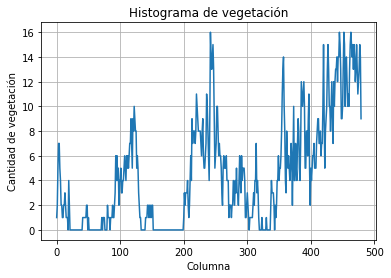

In [35]:
# Calcular histograma de la franja inferior de la imágen, detectar la cantidad de picos según la cantidad
# de lineas se busquen, si hay más o menos de lo buscado se descarta la imagen.
# Luego de calculados los picos, calcular su centroide (la media de la distribución alrededor del pico)

# segment = seg_and[offset_seg_height:offset_seg_height + seg_height, 0:td_w]
h_space = int(morph.shape[0]/12)
# indexes = get_maximum_points(eroded[morph.shape[0] - h_space:morph.shape[0], 0:morph.shape[1]], crop_width_bottom)
#-------
horizontal_segment = reducted[morph.shape[0] - h_space:morph.shape[0], 0:morph.shape[1]]
histogram = column_histogram(horizontal_segment)

# Dibujar linea para mostrar sector analizado, y guarda
# _morph_aux1 = cv2.merge((morph, morph, morph))
# _morph_aux1 = cv2.line(_morph_aux1, (0, morph.shape[0]-h_space),
#                   (morph.shape[1], morph.shape[0]-h_space), (0, 0, 255), 1)
# mostrar_img('line', _morph_aux1)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'segmentToInitialPoints' +'.png', _morph_aux1)
# --------
x = np.arange(0, morph.shape[1], 1)
fig, ax = plt.subplots()
ax.plot(x, histogram)
ax.set(xlabel='Columna', ylabel='Cantidad de vegetación', title='Histograma de vegetación')
ax.grid()
# fig.savefig('img/test/histogram_vegetation.png')
# plt.show()

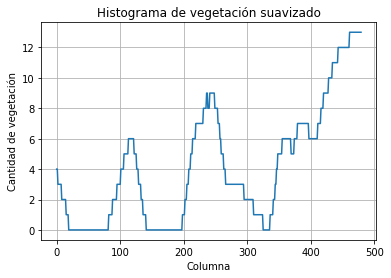

In [36]:
# El tamaño de ventana depende del ancho de las lineas, se busca un valor de manera que suavice y resalte los picos de cultivo
# El grado del polinomio (por prueba) resulto ser mejor con grado 1, y eso puede ayudar en los calculos
# Buscar como implementarlo en c++ (Savitzky Golay filter)

# Sumo uno al ancho para que sea impar, resto 10 para mayor resolución
#-----
crop_width=crop_width_bottom
window_length = int(crop_width*0.4)
window_length = window_length+1 if (window_length%2==0) else window_length
smoothed_2dg = (savgol_filter(histogram, window_length=window_length,
                              polyorder=1)).astype(np.int16)

#------- Manual
# winSize = crop_width_bottom
# winMidSize = int(winSize/2)
# smoothed = np.zeros(histogram.shape, np.int16)
# for i in range(0,len(histogram)):
#     total = 0
#     for j in range(0,winSize):
#         tmp = i - winMidSize + j
#         if (tmp >= 0 and  tmp < len(histogram)):
#             total += histogram[tmp]
#     smoothed[i] = int(total/winSize)

fig, ax = plt.subplots()
ax.plot(x, smoothed_2dg)
ax.set(xlabel='Columna', ylabel='Cantidad de vegetación',
       title='Histograma de vegetación suavizado')
ax.grid()
# fig.savefig('img/test/histogram_vegetation_smoothed.png')
# plt.show()

[Text(0, 0.5, 'Cantidad de vegetación'),
 Text(0.5, 0, 'Columna'),
 Text(0.5, 1.0, 'Máximos locales')]

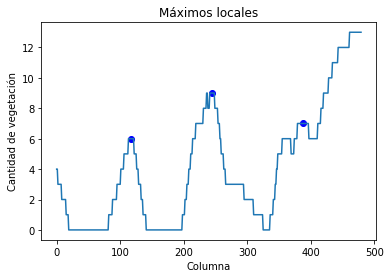

In [37]:
# Detección de picos, basados en una ventana de desplazamiento y punto de inflexión
# Los interpola

indexes = peakutils.indexes(
    smoothed_2dg, thres=0.05/max(smoothed_2dg), min_dist=crop_width_bottom*1.8)

fig, ax = plt.subplots()
ax.plot(x, smoothed_2dg)
ax.scatter(indexes, smoothed_2dg[indexes], c='blue')
ax.set(xlabel='Columna', ylabel='Cantidad de vegetación', title='Máximos locales')

#------------
# histogram = histogram.astype(np.int16)
# indexes = peakutils.indexes(
#     histogram, thres=0.05/max(histogram), min_dist=crop_width_bottom*1.8)

# fig, ax = plt.subplots()
# ax.plot(x, histogram)
# ax.scatter(indexes, histogram[indexes], c='blue')
# ax.set(xlabel='Columna', ylabel='Cantidad de vegetación', title='Máximos locales')
# fig.savefig('img/test/histogram_vegetation_smoothed+peaks.png')
# plt.show()

In [15]:
# Dibujar linea para mostrar sector analizado, y guarda

# _morph_aux1 = cv2.merge((morph, morph, morph))
# _morph_aux1 = cv2.line(_morph_aux1, (0, middle),
#                   (morph.shape[1], middle), (0, 0, 255), 1)
# for i in range(0, len(indexes)):
#     _morph_aux1 = cv2.line(
#         _morph_aux1, (indexes[i], 0), (indexes[i], morph.shape[0]), (255, 0, 0), 2)
#     _morph_aux1 = cv2.line(
#         _morph_aux1, (upper_limit[i], 0), (upper_limit[i], morph.shape[0]), (255, 255, 0), 2)
#     _morph_aux1 = cv2.line(
#         _morph_aux1, (lower_limit[i], 0), (lower_limit[i], morph.shape[0]), (255, 255, 0), 2)
# _morph_aux1 = _morph_aux1[_morph_aux1.shape[0] - h_space:_morph_aux1.shape[0], 0:_morph_aux1.shape[1]]
# mostrar_img('line', _morph_aux1)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'segmentToHough' +'.png', _morph_aux1)

In [27]:
# Se calculan las rectas de Hough que salen de los puntos iniciales, que cumplan con las condiciones de ángulo
# verificar que otras condiciones hay

middle = eroded.shape[0]-int(eroded.shape[0]/2)
bottom_image = morph[middle:eroded.shape[0], 0:eroded.shape[1]]
edges = cv2.filter2D(bottom_image, -1, kernel_edge)
# edges2 = cv2.filter2D(bottom_image, -1, kernel_edge2)
# mostrar_img('edges conv 1', edges)
# mostrar_imgs(['edges conv 1', 'edges conv 2'], [edges,edges2])

In [17]:
# %%timeit -n 10 -r 10
# 19.3 ms ± 525 µs
# Busqueda de líneas con Hough

lines = cv2.HoughLines(edges, 18, np.pi/180, 800)

third_1 = (int)(bottom_image.shape[1]/3)
third_2 = (int)(bottom_image.shape[1]*(2/3))
delta = int(crop_width_bottom/2)
upper_limit = indexes + delta
lower_limit = indexes - delta
groups = {}
if type(lines) is np.ndarray:
    for line in lines:
        for rho, theta in line:
            if (np.sin(theta) != 0):
                m = -(np.cos(theta)/np.sin(theta))
                b = rho/np.sin(theta)
                x = int((bottom_image.shape[0]-b)/m)
                initial_points_condition = False
                group = -1
                for i in range(0, len(indexes)):
                    if (x <= upper_limit[i] and x >= lower_limit[i]):
                        group = i
                # Ángulos de control configurables
                correct_angle_and_position = (x < third_1 and theta < 0.49 and theta > 0.2) or \
                    (x > third_2 and theta < 2.92 and theta > 2.65) or \
                    (x > third_1 and x < third_2 and (theta < 0.39 or theta > 2.75))
#                 correct_angle_and_position = True
                if (x > 0 and x < bottom_image.shape[1] and group != -1 and correct_angle_and_position):
                    line = Line(m,b)
                    line.set_white_amount(bottom_image)
                    if group not in groups.keys():
                        groups[group] = line
                    else:
                        if (groups[group].white_amount < line.white_amount):
                            groups[group] = line
                            
#Si Houghs no detecta rectas que se ajuste a alguno de los grupos, estos quedan vacíos y dan KeyError
# Para ver las rectas obtenidas por TH
# with_lines = cv2.merge((bottom_image, bottom_image, bottom_image))
# for key in groups.keys():
#     line = groups.get(key)
#     m = line.m
#     b = line.b
#     y0 = 0
#     x0 = line.get_x(y0)
#     y1 = with_lines.shape[0]
#     x1 = line.get_x(y1)
#     cv2.line(with_lines, (x0, y0), (x1, y1), (0, 255, 0), 2)

# mostrar_img('Lines with hough', with_lines)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'lines' +'.png', with_lines)

### Cálculo de centroides
* Se utilizan doce segmentos, que se distribuyen cuatro en mitad baja y ocho en la parte alta

In [18]:
# Segmentación de la imagen en partes que disminuyen un 5% cuando se avanza hacia arriba

divisions = cv2.merge((morph, morph, morph))
total_y = morph.shape[0]
y_segments_bottom = np.arange(11,15) # Para obtener los 4 segmentos inferiores
y_segments_top = np.arange(0,9) # Para obtener los 8 segmentos superiores
# Botto: [384, middle], Top: [middle, 0]
y_segments_bottom = (np.multiply((np.true_divide(y_segments_bottom, np.sum(y_segments_bottom))), middle)).astype(np.uint16)
y_segments_top = (np.multiply((np.true_divide(y_segments_top, np.sum(y_segments_top))), middle)).astype(np.uint16)
y_segments_bottom = y_segments_bottom[::-1]
y_segments_top = y_segments_top[::-1]
y_segments_bottom[0] = y_segments_bottom[0] + middle - np.sum(y_segments_bottom)
y_segments_top[0] = y_segments_top[0] + middle - np.sum(y_segments_top)
y_segments = np.concatenate((y_segments_bottom[0:len(y_segments_bottom) - 1], y_segments_top[0:len(y_segments_top)]))
for i in range(len(y_segments) - 2, -1, -1):
    y_segments[i] = y_segments[i] + y_segments[i+1]
y_segments = np.concatenate(([morph.shape[0]], y_segments))

# Para graficar
# for y in y_segments:
#     if y > 0:
#         if (y >= middle):
#             cv2.line(divisions, (0, y),
#                      (morph.shape[1], y), (255, 0, 0), 1)
#         else:
#             cv2.line(divisions, (0, y),
#                      (morph.shape[1], y), (0, 255, 0), 1)

# print('Una cantidad de ' + str(len(y_segments) - 1) + ' segmentos')
# print(y_segments)
# mostrar_img('segments', divisions)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'segmentos' +'.png', divisions)

In [19]:
# Para ver la primera franja con los segmentos de valores de cada línea de cultivo

# bottom_segment = morph[y_segments[1]:y_segments[0],:]
# bottom_segment = cv2.merge((bottom_segment, bottom_segment, bottom_segment))
# mostrar_img('bottom', bottom_segment)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'parte_baja' +'.png', bottom_segment)
# down_ind = indexes - int(crop_width_bottom / 2)
# up_ind = indexes + int(crop_width_bottom / 2)
# for i in range(0, len(indexes)):
#     cv2.line(bottom_segment, (down_ind[i], 0),
#                      (down_ind[i], bottom_image.shape[0]), (255, 255, 55), 2)
#     cv2.line(bottom_segment, (up_ind[i], 0),
#                      (up_ind[i], bottom_image.shape[0]), (255, 255, 55), 2)
#     cv2.line(bottom_segment, (indexes[i], 0),
#                      (indexes[i], bottom_image.shape[0]), (255, 0, 0), 2)
# mostrar_img('abc', bottom_segment)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'parte_baja_con_sectores' +'.png', bottom_segment)

In [20]:
# Dibujo de líneas para corroborar con los centroides que se calculan posteriormente

# divisions_aux1 = divisions.copy()
# img_offset = middle
# for key in groups.keys():
#     line = groups.get(key)
#     m = line.m
#     b = line.b + img_offset
#     y0 = img_offset
#     x0 = int((y0-b)/m)
#     y1 = divisions_aux1.shape[0]
#     x1 = int((y1-b)/m)
#     cv2.line(divisions_aux1, (x0, y0), (x1, y1), (0, 255, 0), 2)
# mostrar_img('lineas', divisions_aux1)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'segmentos_con_TH' +'.png', divisions_aux1)

In [21]:
# Ya que la recta está calculada para la parte inferior, es necesario un offset de b para transladarla
img_offset = middle
for key in groups.keys():
    line = groups.get(key)
    line.b = line.b + img_offset

#### Cálculo de los centroides de la parte inferior de la imagen

In [22]:
# Se calcula el centro del ROI en base a las rectas encontradas por TH
# Si el microROI no tiene píxeles blancos se asume que el centro es el centroide
# Tres vacios consecutivos en una línea es el tope, sino se descarta la imagen <----------------------- a implementar (se puede realizar con un assertion)

# Si se dibujan las rectas para corroborar centroides, comentar estas líneas
divisions_aux1 = divisions.copy()

x_centroids_matrix = np.zeros((len(indexes), len(y_segments) - 1), np.uint16)
y_centroids_matrix = np.zeros((len(indexes), len(y_segments) - 1), np.uint16)
crop_width_aux = crop_width_bottom
width_decay = (crop_width_aux - crop_width_top) / (len(y_segments) - 1)  # (inicial-final)/pasos

segment_index = 1
while y_segments[segment_index] >= middle:
    for key in groups.keys():
        # Obtener cada descriptor de línea
        line = groups.get(key)
        y1, y2 = y_segments[segment_index - 1], y_segments[segment_index]  # Inferior, superior
        # El x del inferior, respecto a la recta
        x_temp = line.get_x(y1)
        # Desplazamientos según ancho de línea
        x1, x2 = x_temp - int(crop_width_aux/2), x_temp + int(crop_width_aux/2)
        if (x1 < 0): x1 = 0
        if (x2 > morph.shape[1]-1): x2 = morph.shape[1]-1
        # Pasarle microimagen con desplazamiento en x e y
        centroid = MicroROI(morph[y2:y1, x1:x2], x1, y2)
        x_centroids_matrix[key, segment_index - 1], y_centroids_matrix[key,
                                                                       segment_index - 1] = centroid.get_centroid()
        # Dibujar el centroide y la micro ROI
        cv2.line(divisions_aux1, (x1, y1), (x1, y2), (255, 255, 0), 1)
        cv2.line(divisions_aux1, (x2, y1), (x2, y2), (255, 255, 0), 1)
        cv2.circle(
            divisions_aux1, (x_centroids_matrix[key, segment_index - 1], y_centroids_matrix[key, segment_index - 1]), 3, (255, 0, 255), 2)
        key = key + 1  # Próxima línea
    # Nuevo ancho de microROI
    crop_width_aux = crop_width_aux - width_decay
    segment_index = segment_index + 1  # Próxima franja

mostrar_img('divisiones y centroides', divisions_aux1)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'centroides' +'.png', divisions_aux1)
# print('pos x')
# print(x_centroids_matrix)
# print('pos y')
# print(y_centroids_matrix)

#### Cálculo de los centroides de la parte superior de la imagen

In [23]:
# En y llevo el nivel actual, calculos la recta de cada línea con los últimos cuatro centroides
# Usar la recta con los últimos cuatro elementos para el ROI del siguiente nivel
# Calcula centroides del siguiente nivel y agregarlos en las matrices correspondientes
divisions_aux2 = divisions_aux1.copy()
# Continuo con el y de la celda anterior, para continuar con los segmentos correspondientes
last_centroids_index = 0
segment_index_aux = segment_index
crop_width_aux2 = crop_width_aux
while segment_index_aux != (len(y_segments)):
    for line_index in range(0, x_centroids_matrix.shape[0]):  # Para cada línea
        # Tomo elementos de [i, i+3] correspondientes a los últimos cuatro centroides
        x_list = x_centroids_matrix[line_index, last_centroids_index:last_centroids_index + 4]
        y_list = y_centroids_matrix[line_index, last_centroids_index:last_centroids_index + 4]
        last_centroid = (x_centroids_matrix[line_index, last_centroids_index+3], y_centroids_matrix[line_index, last_centroids_index+3])
        m, b = least_squares_line(x_list, y_list, last_centroid)
        if (m < 30):
            line = Line(m,b)
        else:
            line = Line(m,x_offset=mean(x_list))
        y1, y2 = y_segments[segment_index_aux-1], y_segments[segment_index_aux]  # Inferior, superior
#         x1, x2 = line.get_x(divisions_aux2.shape[0]), line.get_x(y2)
#         cv2.line(divisions_aux2,
#                  (x1, divisions_aux2.shape[0]), (x2, y2), (0, 0, 255), 2)
        x_temp = line.get_x(y1)
#         x_estimated = line.get_x((y2-y1)/2 + y1)
        # Desplazamientos según ancho de línea
        x1, x2 = x_temp - int(crop_width_aux2 / 2), x_temp + int(crop_width_aux2 / 2)
        # Pasarle microimagen con desplazamiento en x e y
        temp = morph[y2:y1, x1:x2]
        centroid = MicroROI(temp, x1, y2)
        x_centroids_matrix[line_index, segment_index_aux-1], y_centroids_matrix[line_index, segment_index_aux-1] = centroid.get_centroid()
        # Dibujar el centroide y la micro ROI
#         if (line_index == 1):
        cv2.line(divisions_aux2, (x1, y1), (x1, y2), (255, 255, 0), 1)
        cv2.line(divisions_aux2, (x2, y1), (x2, y2), (255, 255, 0), 1)
        cv2.circle(divisions_aux2, (x_centroids_matrix[line_index, segment_index_aux-1], y_centroids_matrix[line_index, segment_index_aux-1]), 3, (255, 0, 255), 2)
    segment_index_aux = segment_index_aux + 1  # Próxima franja
    crop_width_aux2 = crop_width_aux2 - width_decay
    last_centroids_index = last_centroids_index + 1

# print('x')
# print(x_centroids_matrix)
# print('y')
# print(y_centroids_matrix)
mostrar_img('centroides', divisions_aux2)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'centroides_hasta_arriba' +'.png', divisions_aux2)

#### Utilización de ajuste por mínimos cuadrados
* Cálculo de coeficientes de recta: mx+b
* Cálculo de coeficientes de cuadrática: ax^2+bx+c (Implementado, pero no se utiliza)

In [47]:
# Una vez obtenidos todos los centroides de cada línea se realiza una análisis
# de regresión (se puede aplicar a cada conjunto de centroides y obtener los
# descriptores de la curva que mejor se adapte)
# Utiliza nuevamente mínimos cuadrados, y el calculo del resto para quedarse
# con la que mejor se ajuste (recta o cuadrática), se puede detectar la mejor por acumulación de vegetación
divisions_aux3 = divisions_aux2.copy()
y1, y2 = 0, divisions_aux3.shape[0]
y = np.arange(y1, y2)
# v_amount_line = 0


lines = {}
# Independiente, líneal y cuadrático por línea
# quadratic_coef = np.zeros([x_centroids_matrix.shape[0], 3], np.float16)

for line_index in range(0, x_centroids_matrix.shape[0]):  # Para cada línea
    x_list = x_centroids_matrix[line_index, 0:x_centroids_matrix.shape[1]]
    y_list = y_centroids_matrix[line_index, 0:y_centroids_matrix.shape[1]]

    # Mínimos cuadrados para recta
    x_mean = int(mean(x_list))
    y_mean = int(mean(y_list))
    
    m,b = least_squares_line(y_list, x_list, (y_mean, x_mean))
    m = 1/m
    if (m < 80):
        b = - b * m
        lines[line_index] = Line(m,b)
    else:
        lines[line_index] = Line(m,x_offset=x_mean)
#     print(str(line_index)+' ',end='')
#     print(' b:'+str(lines[line_index].b),end='')
#     print(' m:'+str(lines[line_index].m),end='')
#     print(' x_offset:'+str(lines[line_index].x_offset))
    
    x1, x2 = lines[line_index].get_x(y1), lines[line_index].get_x(y2)
    
    cv2.line(divisions_aux3, (x1, y1), (x2, y2), (155, 255, 69), 2)
    
#     lines[line_index].set_white_amount(morph)
#     print(lines[line_index].white_amount)

#     # Mínimos cuadrados para cuadrática
#     quadratic_coef[line_index, 2], quadratic_coef[line_index,
#                                                   1], quadratic_coef[line_index, 0] = least_squares_quadratic(x_list, y_list)
#     x1_quadratic, x2_quadratic = get_x_in_quadratic(
#         y, quadratic_coef[line_index, 2], quadratic_coef[line_index, 1], quadratic_coef[line_index, 0])
    # Guardar los x ya que los calculé, para no recalcular luego
#     x_quadratic = x1_quadratic if (
#         0 < x1_quadratic[0] and x1_quadratic[0] < divisions_aux3.shape[1]) else x2_quadratic
#     if (not np.isnan(x_quadratic).any()):
#         v_amount_quadratic = v_amount_quadratic + get_vegetation_in_quadratic(
#             morph, quadratic_coef[line_index, 2], quadratic_coef[line_index, 1], quadratic_coef[line_index, 0], x_quadratic)
# #         Agregar a imagen
#         pts = np.zeros((x_quadratic.shape[0], 2), np.uint64)
#         for i in range(0, x_quadratic.shape[0]):
#             pts[i, 0] = x_quadratic[i]
#             pts[i, 1] = y[i]
#         cv2.polylines(divisions_aux3, [pts], False, (0, 0, 255), 2)

# print(x_centroids_matrix[1,::])
# print(y_centroids_matrix[1,::])
# print("b: " + str(lines[1,0]) + " y m: " + str(lines[1,1]))
# print('Vegetación en línea: ' + str(v_amount_line))
mostrar_img('total', divisions_aux3)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'cuadratica_minimos_cuadrados' +'.png', divisions_aux3)

### Filtrado de curvas
* Ya que solo se trabaja con rectas, se pospone estos filtros para luego

In [25]:
# Selección y verificación (reglas para verificar que sean rectas/cuadráticas
#válidas)
# 1) Regularidad en el espaciado entre líneas
# 2) No intersección dentro del ROI ni extensión por debajo de la imagen



#Salteo esta parte para luego, ya que las rectas encontradas con la imagen de prueba no tiene problemas

### Generación de máscaras con el uso de curvas descriptoras
* Actuamente solamente con rectas

In [48]:
# Máscaras según el ancho (90 píxeles a ojo, 20px arriba) de cultivo y de surco
# Solo estoy tomando en cuenta la recta, haría falta cambiar esto para utilizar la recta o la cuadrática según corresponda

crop_mask = np.zeros(
    (divisions_aux3.shape[0], divisions_aux3.shape[1]), np.uint8)
entre_surco_mask = crop_mask.copy()
y1, y2 = 0, crop_mask.shape[0]

crop_width_tmp = crop_width_bottom + crop_width_bottom * addition
crop_width_t = crop_width_top + crop_width_top * addition
crop_width_decay = (crop_width_tmp - crop_width_t) / y2

#Debo cambiarlo por obtener el máximo de las distancias
#Es necesario ordenar ya que las rectas pueden no estar en orden de izq a der
furrow_width = int(get_max_distance(np.sort(indexes))) 
# Para calcular el promedio del espacio entre entre líneas en el tope
indexes_top = np.zeros(indexes.shape)
for line_index in range(0, len(lines)):
    indexes_top[line_index] = lines[line_index].get_x(0)
furrow_width_top = int(get_max_distance(np.sort(indexes_top))) 
furrow_width_decay = (furrow_width - furrow_width_top) / y2

In [27]:
for key in lines.keys():
    print(key)
    print(str(lines[key]))

0
m:-4.664679393670325 b:1054.2175429694935 x_offset0 white amount:-1
1
m:-2.9225427119287155 b:1107.6436878209831 x_offset0 white amount:-1
2
m:3.4403816044680235 b:-1217.8950879816803 x_offset0 white amount:-1
3
m:1.9723767911924521 b:-840.2325130479846 x_offset0 white amount:-1


In [27]:
#Creación de las máscaras sin superposición
for y in range(y2 - 1, y1 - 1, -1):  # Desde la base a la parte superior de la imagen
    tmp_crop_width = int(crop_width_tmp/2)
    tmp_furrow_width = int(furrow_width/2)
    for x in range(0, crop_mask.shape[1]):
        result = is_crop_or_furrow_lineal(lines, (x, y), tmp_crop_width, tmp_furrow_width)
        if (result == 1):
            crop_mask[y, x] = 255
        if (result == -1):
            entre_surco_mask[y, x] = 255
    crop_width_tmp = crop_width_tmp - crop_width_decay
    furrow_width = furrow_width - furrow_width_decay

mostrar_imgs(['máscara de cultivo', 'máscara de surco'],
             [crop_mask, entre_surco_mask])

In [ ]:
# Utilizar las máscaras, luego de escalarlas al tamaño original, con AND a la máscara de vegetación
# _crop_mask = cv2.resize(crop_mask, None, fx=(1/rs_ratio),fy=(1/rs_ratio), interpolation=cv2.INTER_AREA)
# entre_surco_mask = cv2.resize(entre_surco_mask, None, fx=(1/rs_ratio),fy=(1/rs_ratio), interpolation=cv2.INTER_AREA)

# cv2.imwrite(path_to_imgs + file_name + '_'+ 'mascara_cultivo' +'.png', _crop_mask)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'mascara_surco' +'.png', entre_surco_mask)

# _crop_mask = cv2.bitwise_and(_crop_mask, segmented)
# entre_surco_mask = cv2.bitwise_and(entre_surco_mask, segmented)

# Para la versión reducida
crop_mask_aux1 = cv2.bitwise_and(crop_mask, reducted)
furrow_crop_mask_aux1 = cv2.bitwise_and(entre_surco_mask, reducted)
# mostrar_imgs(['máscara de cultivo', 'máscara de surco'],
#              [crop_mask_aux1, furrow_crop_mask_aux1])

# cv2.imwrite(path_to_imgs + file_name + '_'+ 'mascara_cultivo_veg' +'.png', crop_mask_aux1)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'mascara_surco_veg' +'.png', furrow_crop_mask_aux1)

### Prueba de distribución
* Hace falta aislar píxeles de maleza

In [ ]:
# Preparación de datos para comparar distribución entre datos de crop y weed

# x_v = []
# y_v = []
# z_v = []
# x_w = []
# y_w = []
# z_w = []
# v_data = []
# w_data = []
# v_i = 0
# w_i = 0
# tope = 300000
# for x in range(0,segmented.shape[1]):
#     for y in range(0, segmented.shape[0]):
#         if (_crop_mask[y,x] == 255) and (v_i < tope):
#             v_i = v_i + 1
#             v_data.append(original[y,x])
#             x, y, z = original[y,x]
#             x_v.append(x)
#             y_v.append(y)
#             z_v.append(z)
# #             v_data.append(original[y,x])
#         if (_furrow_crop_mask[y,x] == 255) and (w_i < tope):
#             w_i = w_i + 1
#             w_data_data.append(original[y,x])
#             x, y, z = original[y,x]
#             x_w.append(x)
#             y_w.append(y)
#             z_w.append(z)
# #             w_data.append(original[y,x])
# x_v = np.array(x_v)
# y_v = np.array(y_v)
# z_v = np.array(z_v)
# x_w = np.array(x_w)
# y_w = np.array(y_w)
# z_w = np.array(z_w)
# v_data = np.array(v_data)
# w_data = np.array(w_data)

In [ ]:
# fix, ax = plt.subplots(1,2, sharey=True)
# sns.boxplot(data=v_data, linewidth=2.5, palette='Set3', ax=ax[0])
# sns.boxplot(data=w_data, linewidth=2.5, palette='Set1', ax=ax[1])
# fig = plt.figure()
# ax1 = fig.add_subplot(111, projection='3d')
# ax1.scatter(x_v, y_v, z_v, c='g', marker='o')
# ax1.scatter(x_w, y_w, z_w, c='r', marker='o')
# plt.show()

## Clasificación en cuadrantes

In [ ]:
# Tengo L: líneas y L+1: Surcos
# Sabiendo el espaciado entre líneas, puedo calcular en que surco estoy
# Tengo los índices de las franjas horizontales

# Aplicar apertura o erosiones sobre la máscara de surco
#kernel = np.ones((7,7),np.uint8)
#apertura = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# _furrow_crop_mask_aperture = (cv2.erode(furrow_crop_mask_aux1, kernel))
_furrow_crop_mask_aperture = cv2.morphologyEx(
    furrow_crop_mask_aux1, cv2.MORPH_OPEN, kernel, iterations=1)
# _furrow_crop_mask_aperture = cv2.morphologyEx(
#     _furrow_crop_mask_aperture, cv2.MORPH_CLOSE, kernel, iterations=1)
# for i in range(0, 0):
#     _furrow_crop_mask_aperture = cv2.morphologyEx(
#         _furrow_crop_mask_aperture, cv2.MORPH_OPEN, kernel_vertical, iterations=1)
#     _furrow_crop_mask_aperture = cv2.morphologyEx(
#         _furrow_crop_mask_aperture, cv2.MORPH_OPEN, kernel_diagonal_1, iterations=1)
#     _furrow_crop_mask_aperture = cv2.morphologyEx(
#         _furrow_crop_mask_aperture, cv2.MORPH_OPEN, kernel_diagonal_2, iterations=1)
#     _furrow_crop_mask_aperture = cv2.morphologyEx(
#         _furrow_crop_mask_aperture, cv2.MORPH_OPEN, kernel_horizontal, iterations=1)
tmp_red = cv2.resize(original, None, fx=rs_ratio*1.5,fy=rs_ratio*1.5, interpolation=cv2.INTER_AREA)
mostrar_imgs(['orig', 'segment', 'apert'], [tmp_red ,furrow_crop_mask_aux1,
                                 _furrow_crop_mask_aperture])

# Gurdado para hacer comparativa
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'apertura1' +'.png', _furrow_crop_mask_aperture)

In [ ]:
# Aplicar las máscaras de vegetación y de cultivo para clasificar visualmente
# _crop_mask_aux = cv2.resize(crop_mask, None, fx=(1/rs_ratio),fy=(1/rs_ratio), interpolation=cv2.INTER_AREA)
# _furrow_crop_mask_aux = cv2.resize(_furrow_crop_mask_aperture, None, fx=(1/rs_ratio),fy=(1/rs_ratio), interpolation=cv2.INTER_AREA)
# zeros = np.zeros(_crop_mask_aux.shape, np.uint8)
# mask = cv2.merge((zeros, _crop_mask_aux, _furrow_crop_mask_aux))
# total = cv2.add(original, mask)
# mostrar_imgs(['original', 'clasificada'], [original, total], reduction_to_see)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'clasificado' +'.png', total)

### Clasificación de maleza por sectores
* Se basa en la cantidad de vegetación en surco, luego de aplicar operaciones de eliminación de ruido

In [ ]:
# Se puede disminuir el costo verificando solo en la parte interna de la máscara de maleza, hace falta conseguir puntos que pertenecen a ella
# Con whiles podría quitar varios saltos, comprobaciones y cálculos

__furrow_crop_mask = entre_surco_mask.copy()
# Itero sobre cada franja
for y_index in range(0, len(y_segments) - 1):  # Itera 12 veces, una por segmento
    # En cada franja separo en cuadrantes separados por líneas de cultivo (cantidad de líneas + 1)
    # En cada cuadrante le sumo la cantidad de vegetación y el tamaño (tamaño tendrá 1 más para no dividir por 0)
    weed_amount = np.zeros(len(lines) + 1, np.uint16)
    total_pxls = np.ones(len(lines) + 1, np.uint16)
    x_by_line = np.zeros(len(lines), np.uint16)
    # Obtengo los x de cada línea en la base de la franja, para realizar la separación por cuadrantes
    for i in range(0, len(lines)):  # Itera #L veces
        x_by_line[i] = lines[i].get_x(y_segments[y_index])
    # Itero en la franja correspondiente
    # Itera el alto de segmento (máx es 1/12 * (alto de imagen disminuida))
    for y in range(y_segments[y_index + 1], y_segments[y_index]):
        furrow_index = 0
        x = 0
        # Itera máx el ancho de la imagen
        while ((furrow_index < len(weed_amount)) and (x < crop_mask.shape[1])):
            # Me saco todos los 0's del comienzo, si es que tiene
            while ((x < crop_mask.shape[1]) and (entre_surco_mask[y, x] == 0)):
                x = x + 1
            # Colóco el índice donde pertenece
            while ((furrow_index < x_by_line.shape[0]) and (x >= x_by_line[furrow_index])):
                furrow_index = furrow_index + 1
            while ((x < crop_mask.shape[1]) and (entre_surco_mask[y, x] == 255)):
                # Procesamiento dentro de surco
                total_pxls[furrow_index] = total_pxls[furrow_index] + 1
                if _furrow_crop_mask_aperture[y, x] > 10:
                    weed_amount[furrow_index] = weed_amount[furrow_index] + 1
                x = x + 1
            furrow_index = furrow_index + 1
    # Adapto la máscara de surco acorde a si cada cuadrante pasa un porcentaje de maleza
    weed_porc = 0.10
    weed_amount = np.true_divide(weed_amount, total_pxls)
    for y in range(y_segments[y_index + 1], y_segments[y_index]):
        furrow_index = 0
        x = 0
        # Itera máx el ancho de la imagen
        while ((furrow_index < len(weed_amount)) and (x < crop_mask.shape[1])):
            # Me saco todos los 0's del comienzo, si es que tiene
            while ((x < crop_mask.shape[1]) and (entre_surco_mask[y, x] == 0)):
                x = x + 1
            # Colóco el índice donde pertenece
            while ((furrow_index < x_by_line.shape[0]) and (x >= x_by_line[furrow_index])):
                furrow_index = furrow_index + 1
            if (furrow_index >= len(weed_amount)):
                print('fuera de rango y: ' + str(y) + ',x: ' +
                      str(x) + 'furr ind: ' + str(furrow_index))
            _data = 0 if (furrow_index < len(weed_amount)
                          and weed_amount[furrow_index] < weed_porc) else 255
            while ((x < crop_mask.shape[1]) and (entre_surco_mask[y, x] == 255)):
                __furrow_crop_mask[y, x] = _data
                x = x + 1
            furrow_index = furrow_index + 1
#         weed_porc = weed_porc - weed_porc_red

# Sectorización de la máscara
__furrow_crop_mask_aux = __furrow_crop_mask.copy()
for y in y_segments:
    cv2.line(__furrow_crop_mask_aux, (0, y),
             (morph.shape[1], y), 255, 1)
# mostrar_img('furrow', __furrow_crop_mask_aux)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'Sectores' +'.png', __furrow_crop_mask_aux)

# Clasificación sectorizada
_crop_mask = cv2.resize(crop_mask, None, fx=(
    1/rs_ratio), fy=(1/rs_ratio), interpolation=cv2.INTER_AREA)
_furrow_crop_mask_aux = cv2.resize(__furrow_crop_mask, None, fx=(
    1/rs_ratio), fy=(1/rs_ratio), interpolation=cv2.INTER_AREA)
zeros = np.zeros(_crop_mask.shape, np.uint8)
mask = cv2.merge((zeros, _crop_mask, _furrow_crop_mask_aux))
total = cv2.add(original, mask)
mostrar_imgs(['original', 'clasificada'], [original, total], reduction_to_see)
# cv2.imwrite(path_to_imgs + file_name + '_'+ 'clasificado_sectores' +'.png', total)